<center><h1><font color="orange">BiDirectional LSTMs for Named Entity Recognition Tasks</font></h1></center>
<p>In this notebook we will be exploring the usage of BiDirectional Long Short Term Memory (LSTM) Neural Networks in conjunction with Conditional Random Fields (CRF) for named entity recognition (NER) tasks. NER seeks to locate and classify named entity mentions in unstructured text into pre-defined categories such as the person names, organizations, locations, medical codes, time expressions, quantities, monetary values, percentages, etc. For example, say we want to extract people and geographical locations from the following sentence: </p>
<p><i>Frank went to Paris</i><p>
<p>An NER model would return Frank tagged as person and Paris tagged as geographical location.</p>
<p>In the financial payment industry, financial institutions commonly use mediums such as email and text to facilitate a payment from one account to another. A recipient manually parses this email and then structures the extracted data for upload to an FFDC API that facilitates the deal.</p>
<p>We will create a BiDirectional LSTM with a CRF layer that performs NER on these emails and uses Finastra's FFDC API's to initiate the payment. In this notebook you will learn about natural language processing (NLP), LSTMs, BiDirectional LSTMs, Conditional Random Fields (CRFs), OAuth2 authentication, and APIs.</p> 

<h4>Imports:</h4>
<p>We use the following imports for data handling, visualization, machine learning, and accessing APIs. If you are missing any of these libraries in your python environment, you can use the pip package installer to install them.</p>

In [1]:
#Data Handling Imports 
import pandas as pd
import numpy as np
import json
import string
import warnings
warnings.filterwarnings("ignore")

#NLP Imports
import re 
import nltk

#API Handling
import requests

#Machine Learning Imports
from sklearn.model_selection import train_test_split
from sklearn_crfsuite import CRF
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn_crfsuite import CRF as skCRF
import joblib
from keras_contrib.layers import CRF
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
from keras import backend as K
from keras.utils import to_categorical
from keras.models import Model, Input, load_model
from keras.layers.merge import add
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda
from keras_contrib.layers import CRF
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

#Printing Output
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
    
#Visualization
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pygal
from pygal.style import Style
from IPython.display import display, HTML

Using TensorFlow backend.


<h4>Load Data:</h4>
<p>First, we need to load our dataset. This dataset contains an unstructured email as well as tagged features for the amount, the account sending money (accountA), the account receiving money (accountB), and the currency.</p>

In [2]:
df = pd.read_csv('data9.csv',sep='|')
df.head()

,email,amount,accountA,accountB,currency
0,Please move 4101673 OMR dollars from account n...,4101673,nZ,mg,OMR
1,Hi this is Elizabeth Scott. I need you to help...,2696601,iVwSfPBu,42jrfwc,IRR
2,Move $ 9462209 NAD to 205605460 from 839079808...,9462209,839079808,205605460,NAD
3,Please move 889295 ARN dollars from account 22...,889295,22,1,ARN
4,Please take account EPYFGRXN6Q and move $ 4804...,4804519,EPYFGRXN6Q,YSAWZNQ,CZK


<p>Sample Email: </p>

In [3]:
print(df.iloc[1].email)

Hi this is Elizabeth Scott. I need you to help me transfer 2696601 IRR from iVwSfPBu into 42jrfwc. How soon can this be completed? Please let me know.


<h4>Clean Data:</h4>
<p>Since we have unstructured text data, we need to clean it up a bit for our machine learning model. We will perform some operations such as removing parentheses and brackets, fixing punctuation, and adjusting currency notation.</p>

In [4]:
def remove_parentheses(i): 
    return re.sub('[()""“”{}<>]', '', i)

def remove_brackets(i): 
    i = i.replace('[',"")
    i = i.replace(']',"")
    return i

def fix_punct(i): 
    i = re.sub(r"([a-z]+)([.()!])", r'\1 ',i)
    i = i.replace(".", " ")
    i = i.replace("?"," ")
    i = i.replace("!", " ")
    i = i.strip()
    return i

def fix_curr(i):
    txt = re.sub(r"\$([0-9+])", "$ \\1", i)
    return txt 

df['email'] = df['email'].apply(lambda i: fix_punct(i))
df['email'] = df['email'].apply(lambda i: remove_brackets(i))
df['email'] = df['email'].apply(lambda i: remove_parentheses(i))
df['email'] = df['email'].apply(lambda i: fix_curr(i))
df['amount'] = df['amount'].apply(lambda i: str(i))
df['accountA'] = df['accountA'].apply(lambda i: str(i))
df['accountB'] = df['accountB'].apply(lambda i: str(i))

<p>Sample Cleaned Email: </p>

In [5]:
print(df.iloc[1].email)

Hi this is Elizabeth Scott  I need you to help me transfer 2696601 IRR from iVwSfPBu into 42jrfwc  How soon can this be completed  Please let me know


<h4>Word Cloud</h4>
<p>Let's explore the cleaned data by first checking out a word cloud. This will give us a visualization of the most popular words in our dataset. We check out the top 100 below:</p>

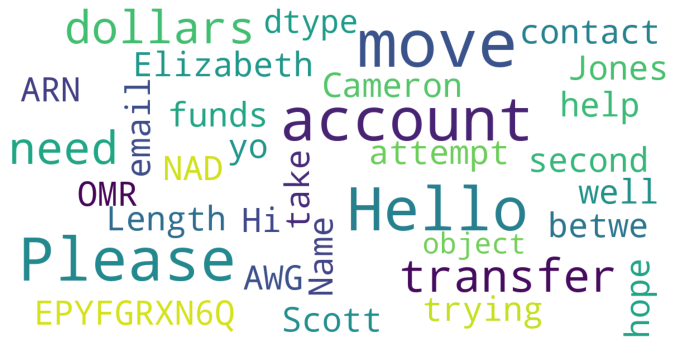

In [6]:
stopwords = set(STOPWORDS)
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        contour_color='steelblue',
        stopwords=stopwords,
        max_words=100,
        max_font_size=40, 
        scale=3,
        random_state=1 
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(df.email)

<h4>Word Lengths:</h4>
<p>Let's take a look at some descriptive statistics of the length of the emails:</p>

In [7]:
stats = ['mean','std','25%','50%','75%','max']
df_stats = df.email.str.split().apply(len).value_counts().describe()
for i in stats: 
    print(i+':',df_stats[i])

mean: 270.0
std: 355.3960136673064
25%: 74.75
50%: 162.0
75%: 342.25
max: 1726.0


<h4>Extract Sentences and Labels:</h4>
<p>Now that we have our cleaned data, we need to pull out the individual emails and zip together a list of the labels. The labels will be the amount, accountA, accountB, and currency. We will use these lists to generate our pre-features and later on our features.</p>

In [8]:
sentences = df.email.values.tolist()
labels = list(zip(df.amount.values.tolist(),df.accountA.values.tolist(),df.accountB.values.tolist(), df.currency.values.tolist()))
print("Sample Cleaned Sentence:")
print(sentences[0])
print("\nSample Labels:")
print(labels[0])

Sample Cleaned Sentence:
Please move 4101673 OMR dollars from account nZ to mg

Sample Labels:
('4101673', 'nZ', 'mg', 'OMR')


<h4>Obtain Pre-Feature Vector:</h4>
<p>We now need to generate a pre-feature vector. We will loop over all of our data, tokenize the sentences, generate the part of speech for each token in the sentence, and append our labels. This constitutes our pre-feature vector.</p>

In [9]:
pre_feats = []

#loop over each sentence and tokenize it separately
for sidx, s in enumerate(sentences):
    sent_text = nltk.sent_tokenize(s) # this gives us a list of sentences
    for idx,sentence in enumerate(sent_text):
        sent_labels = []
        all_info = []
        tokenized_text = nltk.word_tokenize(sentence)
        for j in tokenized_text: 
            if j == labels[sidx][0]: 
                sent_labels.append('amount')
            elif j == labels[sidx][1]: 
                sent_labels.append('accountA')
            elif j == labels[sidx][2]: 
                sent_labels.append('accountB')
            elif j == labels[sidx][3]:
                sent_labels.append('currency')
            else: 
                sent_labels.append('O')
        tagged = nltk.pos_tag(tokenized_text)

        for idx2, tag in enumerate(tagged): 
            l = (tag[0],tag[1],sent_labels[idx2])
            all_info.append(l)
        pre_feats.append(all_info)
        
print("Sample Pre-Feature Vector:")
print(pre_feats[0])

Sample Pre-Feature Vector:
[('Please', 'NNP', 'O'), ('move', 'VB', 'O'), ('4101673', 'CD', 'amount'), ('OMR', 'NNP', 'currency'), ('dollars', 'NNS', 'O'), ('from', 'IN', 'O'), ('account', 'NN', 'O'), ('nZ', 'NN', 'accountA'), ('to', 'TO', 'O'), ('mg', 'VB', 'accountB')]


<h4>Feature Vectors:</h4>
<p>We will now take the above vectors and create the vectors that will be used to train/test our machine learning model:</p>
<ul>
    <li>Input - A padded feature vector where each value is an enumerated position of a word</li>
    <li>Target - A one hot encoded vector where a 1 representes the position of the tag</li>
</ul>

In [10]:
def get_feature_vecs(max_len,sentences):
    #Get set of words and tags in dataset
    words, tags = [],[]
    for i in sentences: 
        for j in i: 
            words.append(j[0])
            tags.append(j[2])
    words = list(set(words))
    words.append("ENDPAD")
    tags = list(set(tags))
    n_words = len(words)
    n_tags = len(tags)
    
    #Create feature vector
    word2idx = {w: i + 1 for i, w in enumerate(words)}
    tag2idx = {t: i for i, t in enumerate(tags)}
    
    #Format input
    X = [[word2idx[w[0]] for w in s] for s in sentences]
    X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words-1)

    #Format target
    y = [[tag2idx[w[2]] for w in s] for s in sentences]
    y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])
    y = [to_categorical(i, num_classes=n_tags) for i in y]
    return X, y, n_words, n_tags, words, tags

In [11]:
max_len = 32 #We choose a 32 dimensional vector as feature input
X, y, n_words, n_tags, words, tags = get_feature_vecs(max_len,pre_feats)

In [12]:
print("Sample Feature Vector:")
print(X[20])
print("\nSample Feature Label")
print(y[20])

Sample Feature Vector:
[32621 24421  7935  1418 31811 32488 19453  8996 17801 11630 30511 21464
 30822 32903 33049 15597 18381  6128  9599   221 21906 26849 10030 15904
 14057 16034 21906 33944 25954 32909  3615  2993]

Sample Feature Label
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


<h4>Train/Test Split:</h4>
<p>We now need to split our data into a training and testing set so we can properly evaluate our machine learning model. We use the train_test_split function from the sklearn library. We will also keep track of the indices in our train/test set.</p>

In [13]:
indices = range(X.shape[0])
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(X, y,indices, test_size=0.10, random_state=42)

<h2>Recurrent Neural Networks:</h2>
<p>Humans have an incredibly fast process of comprehension. As we are reading this text, we understand each word based on our understanding of the previous words. We do not read each word, throw away what we have learned and start learning the next words. Our thoughts have persistence and follow a sequential thought order.</p>
<p>If we take a look at a regular feed forward neural network, we see that there is no persistence. These networks don't allow us to sequentially reason from previous events to inform later ones.</p>
<img src="Images/rnn0.png"/>
<p>Above, we have a segment of neural network $A$ that looks at some input $x_t$ and outputs a value $h_t$. There is a loop which allows information to be passed from one step of the network to the next. RNNs are called recurrent because they perform the same task for every element of a sequence, with the output being dependant on the previous computations we know that have a memory which captures information about what has so far been calculated.</p>
<p>More specifically, for each hidden state $h$ we derive $y$ through the follwing equations:</p>
<p>Here, $W_{xh}x_t$ is the multiplication of input $x_t$ by a weight matrix $W_{xh}$, which is essentially a way for the hidden layer to exract information out of the input. $W_{hh}H_{t-1}$ allows the network to extract information out of the entire history of past inputs to compute the output. We let $f$ and $g$ be activation functions and $b_1$ and $b_2$ be biases.</p>
<img src="Images/rnn2.png"/>
<p>We can see this process below:</p>
<img src="Images/rnn1.png"/>
<p>RNNs are great for a variety of sequential tasks, but can suffer when the gap between the relevant information and the point where the information is needed becaomes very large. As this gap grows, RNNs become unable to learn to connect this information. However, we can turn to LSTMs to solve this problem.</p>

<h2>LSTMs:</h2>
<p>LSTMs are a special type of RNN that is capable of learning long-term dependencies. Remembering information for long periods of time is their default behavior. The rerpeating module in an LSTM looks as follows:</p>
<img src="Images/lstm0.png"/>
<p>With LSTMS there are 4 gates.</p>
<h5>Gate 1: Forget Gate Layer</h5>
<p>This decides what information we are going to throw away from the cell state. This looks at $h_{t-1}$ and $x_t$ and applys a sigmoid to output a number between 0 and 1.</p>
<img src="Images/lstm1.png"/>
<h5>Gate 2: What Information to Store</h5>
<p>The next step is what information we are going to store. We have a sigmoid layer called the Input gate layer that decides which values to update and then a tanh layer that creates new candidate values.</p>
<img src="Images/lstm2.png"/>
<h5>Gate 3: The Update</h5>
<p>We now drop the things we forgot earlier and add the new information.</p>
<img src="Images/lstm5.png"/>
<h5>Gate 4:  The Output</h5>
<p>Now we decide what we are going to output. We run a sigmoid layer which decides which parts of the sell state we will output. We then put the cell state through tanh and multiply it by tthe output of the sigmoid gate.</p>
<img src="Images/lstm4.png"/>

<h4>Bidirectional LSTM:</h4>
<p>A bidirectional lstm simply runs our input two ways, one from past to future and one from future to past. This can help us better understand context. The architecture looks as follows:</p>
<img src="Images/bidirectionallstm0.png"/>

<h4>Conditional Random Field:</h4>
<p>Conditional Random Fields are another model for predicting sequences, using information from previous labels and thus increasing the amount of information the model has to make a good prediction. A CRF boils down to solving:</p>
<img src="Images/crf0.png"/>

<h4>Create Bidirectional LSTM + CRF Model:</h4>
<p>We now create the neural by having an input layer, an embedding layer, a bidirectional LSTM layer, and wrap a CRF layer around it.</p>

In [14]:
#Create the Bidirectional LSTM
input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words + 1, output_dim=20,input_length=max_len, mask_zero=True)(input)
model = Bidirectional(LSTM(units=50, return_sequences=True,recurrent_dropout=0.1))(model)  
model = TimeDistributed(Dense(50, activation="relu"))(model)

#Create the CRF
crf = CRF(n_tags) 

#Put the Bidirectional LSTM in the CRF
out = crf(model)

#Create one model from the two models
model = Model(input, out)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


<h4>Train Model:</h4>
<p>We now train the CRF model with our training data. We picked 4 epochs and a batch size of 64. These are parameters we can change if we want to see how varying these may influence the results. </p>

In [15]:
history = model.fit(X_train, np.array(y_train), batch_size=64, epochs=4, verbose=1,validation_data=(X_test,np.array(y_test)))

Instructions for updating:
Use tf.cast instead.
Train on 12150 samples, validate on 1350 samples
Epoch 1/4
12150/12150 [==============================] - 15s 1ms/step - loss: 0.4398 - crf_viterbi_accuracy: 0.8708 - val_loss: 0.2777 - val_crf_viterbi_accuracy: 0.8921
Epoch 2/4
12150/12150 [==============================] - 13s 1ms/step - loss: 0.1641 - crf_viterbi_accuracy: 0.9393 - val_loss: 0.0415 - val_crf_viterbi_accuracy: 0.9892
Epoch 3/4
12150/12150 [==============================] - 17s 1ms/step - loss: 0.0183 - crf_viterbi_accuracy: 0.9956 - val_loss: 0.0077 - val_crf_viterbi_accuracy: 0.9983
Epoch 4/4
12150/12150 [==============================] - 27s 2ms/step - loss: 0.0040 - crf_viterbi_accuracy: 0.9990 - val_loss: 0.0023 - val_crf_viterbi_accuracy: 0.9994


<h4>Model Performance:</h4>
<p>Below we see the model accuracy and loss over our epochs. We will also look at a classification report to see our precision, recall, and f1 score on our testing set.</p>

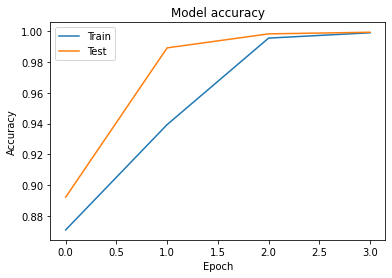

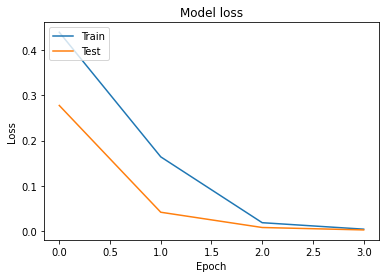

In [16]:
plt.plot(history.history['crf_viterbi_accuracy'])
plt.plot(history.history['val_crf_viterbi_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

<p>As the number of epochs increase, the accuracy also increases, and the loss decreases.</p>

In [17]:
test_preds = model.predict(X_test)

score, acc = model.evaluate(X_test, np.array(y_test),
                            batch_size=64)
print("\nModel Test Accuracy: ", acc)

flat_test_preds = []
for i in test_preds: 
    flat_test_preds.append(i.flatten())
    
flat_actual = []
for i in y_test: 
    flat_actual.append(i.flatten())

print("\n",flat_classification_report(np.array(flat_test_preds), np.array(flat_actual)))

1350/1350 [==============================] - 1s 590us/step

Model Test Accuracy:  0.999375

               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    172800
         1.0       1.00      1.00      1.00     43200

    accuracy                           1.00    216000
   macro avg       1.00      1.00      1.00    216000
weighted avg       1.00      1.00      1.00    216000



<h4>Model Output:</h4>
<p>We create a function below to format help us view a cleaned version of our model output so we can see for each email the actual vs. predicted tags.</p>

In [18]:
def view_model_output(i,X_test,y_test,words,tags,pred):
    p = model.predict(np.array([X_test[i]]))
    p = np.argmax(p, axis=-1)
    true = np.argmax(y_test[i], -1)
    print("{:15}{:15}{}".format("Word", "Actual", "Prediction"))
    print(45 * "=")
    results = {}
    for w, t, pred in zip(X_test[i], true, p[0]):
        if w != 0 and w!= len(words)-1:
            print("{:15}: {:15} {}".format(words[w-1], tags[t], tags[pred]))
            if tags[t] != "O": 
                results[tags[t]] = words[w-1]
    return results
                        
d_result = view_model_output(7,X_test,y_test,words,tags,test_preds)
print()
print(sentences[indices_test[7]])
print()
print(d_result)

Word           Actual         Prediction
Hi             : O               O
this           : O               O
is             : O               O
Noah           : O               O
Clark          : O               O
I              : O               O
need           : O               O
you            : O               O
to             : O               O
do             : O               O
the            : O               O
following      : O               O
Please         : O               O
help           : O               O
me             : O               O
transfer       : O               O
6298950        : amount          amount
GGP            : currency        currency
from           : O               O
879725174      : accountA        accountA
into           : O               O
779227360      : accountB        accountB
Thanks         : O               O

Hi this is Noah Clark  I need you to do the following  Please help me transfer 6298950 GGP from 879725174 into 779227360  Thank

<h4>Save Model:</h4>
<p>We now save our model so we can load it and use it in the future. Since we have a custom CRF layer we need to create a quick function so that when we load it, we get no errors.</p>

In [19]:
filename = 'model_final.h5'
model.save(filename)

In [20]:
from keras_contrib.layers import CRF
from keras.models import load_model

def create_custom_objects():
    instanceHolder = {"instance": None}
    class ClassWrapper(CRF):
        def __init__(self, *args, **kwargs):
            instanceHolder["instance"] = self
            super(ClassWrapper, self).__init__(*args, **kwargs)
    def loss(*args):
        method = getattr(instanceHolder["instance"], "loss_function")
        return method(*args)
    def accuracy(*args):
        method = getattr(instanceHolder["instance"], "accuracy")
        return method(*args)
    return {"ClassWrapper": ClassWrapper ,"CRF": ClassWrapper, "loss": loss, "accuracy":accuracy}

def load_keras_model(path):
    model = load_model(path, custom_objects=create_custom_objects(),compile=False)
    return model

model2 = load_keras_model(filename)
model2.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

<h4>Authentication Token:</h4>
<p>The first step to using our FFDC APIs is authenticating. We have a csv called config.csv which has our application id, access key, reply url, token endpoint, and base url. The following class allows us to authenticate. When we get a 200 as a response it means we are fully authenticated and ready to use the endpoints.</p>

In [21]:
class authenticate: 
    def __init__(self,config_file): 
        self.df = pd.read_csv(config_file)
        self.client_id = self.df['application_id'].values[0]
        self.client_secret = self.df['access_key'].values[0]
        self.reply_url = self.df['reply_url'].values[0]
        self.token_endpoint = self.df['token_endpoint'].values[0]
        self.base_url = self.df['base_url'].values[0]
        
    def get_token(self): 
        headers = {
        }
        data = {
            'grant_type'     : 'client_credentials',
            'client_id'      : self.client_id,
            'client_secret'  : self.client_secret
        }
        response = requests.request('POST', self.token_endpoint, data=data, headers=headers)
        print(response)
        cleaned_response = response.text.replace(':null', ':"null"')
        response_dict = eval(cleaned_response)
        token = response_dict['access_token']
        return response, token
    
a = authenticate('config.csv')
response,token = a.get_token()
print(response.status_code)

<Response [200]>
200


<h4>Sample Post:</h4>
<p>Since we are just sending the debitor, creditor, amount, and currency we can directly modify this sample instead of recreating it each time.</p>

In [22]:
sample_post = {
  "initiatingParty": "DHILDHILXXX",
  "paymentInformationId": "MMSTADV52788051",
  "paymentMethod": "TRF",
  "requestedExecutionDate": "2018-08-28",
  "paymentIdentification": {
    "instructionIdentification": "MMSTADV52788051",
    "endToEndIdentification": "MMSTADV52788051"
  },
  "instructionPriority": "Normal",
  "chargeBearer": "FollowingServiceLevel",
  "instructedAmount": {
    "amount": 100.11,
    "currency": "ILS"
  },
  "debitorAgent": {
    "identification": "EATCIL2WXXX"
  },
  "debtorAccountId": {
    "identificationType": "PrimaryAccountNumber",
    "identification": "8888888888",
    "name": "Name",
    "currency": "USD"
  },
  "creditor": {
    "name": "Name",
    "postalAddress": {
      "addressLine": [
        "68 Rue de Charenton"
      ],
      "street": "Street Name",
      "buildingNumber": "14",
      "postalCode": "70018",
      "city": "City",
      "country": "SG"
    }
  },
  "creditorAgent": {
    "identification": "WPACIL2WXXX"
  },
  "creditorAccountId": {
    "identificationType": "PrimaryAccountNumber",
    "identification": "999999999"
  },
  "relatedRemittanceInformation": {
    "remittanceIdentification": "RmtId1234",
    "remittanceLocationMethod": "URID",
    "remittanceLocationElectronicAddress": "Location"
  },
  "remittanceInformationUnstructured": "RmtInf1234"
}

<h4>POST request to Payments API:</h4>
<p>We can use the following class to make a POST request to the payment-initiation API. Note the payment intiation endpoint in the base URL in our __init__ method and the connect endpoint, which posts the paylod.</p>

In [23]:
class payments_api: 
    def __init__(self,token,method,payload,additional_headers={},params = None): 
        self.token = token 
        self.endpoint_type = method
        self.base_url = 'https://api.preprod.fusionfabric.cloud/payment/payment-initiation/v1/credit-transfer/international/initiate'
        self.additional_headers = additional_headers
        self.params = params
    
    def connect_endpoint(self):
        self.url = self.base_url 
        headers = {
            'Authorization': 'Bearer ' + self.token,
            'Content-Type' : 'application/json'
            }
        for key in self.additional_headers.keys():
            headers[key] = self.additional_headers[key]
        stringified_payload = json.dumps(payload)
        response = requests.request(self.endpoint_type, self.url, params=self.params, data=stringified_payload,headers=headers)
        return response

<h4>Format Extracted Data:</h4>
<p>We now take our results from the sentence below and pass the model's predictions of the debitor account, creditor account, amount, and currency to the API in a JSON structure.</p>

In [24]:
sentences[indices_test[7]]

'Hi this is Noah Clark  I need you to do the following  Please help me transfer 6298950 GGP from 879725174 into 779227360  Thanks'

In [25]:
print("Results: ",d_result,"\n")
payload = sample_post
payload['debtorAccountId']['name'] = d_result['accountB']
payload['creditor']['name'] = d_result['accountA']
payload['instructedAmount']['amount'] = float(d_result['amount'])
payload['instructedAmount']['currency'] = d_result['currency']
print("Payload:\n",payload)

Results:  {'amount': '6298950', 'currency': 'GGP', 'accountA': '879725174', 'accountB': '779227360'} 

Payload:
 {'initiatingParty': 'DHILDHILXXX', 'paymentInformationId': 'MMSTADV52788051', 'paymentMethod': 'TRF', 'requestedExecutionDate': '2018-08-28', 'paymentIdentification': {'instructionIdentification': 'MMSTADV52788051', 'endToEndIdentification': 'MMSTADV52788051'}, 'instructionPriority': 'Normal', 'chargeBearer': 'FollowingServiceLevel', 'instructedAmount': {'amount': 6298950.0, 'currency': 'GGP'}, 'debitorAgent': {'identification': 'EATCIL2WXXX'}, 'debtorAccountId': {'identificationType': 'PrimaryAccountNumber', 'identification': '8888888888', 'name': '779227360', 'currency': 'USD'}, 'creditor': {'name': '879725174', 'postalAddress': {'addressLine': ['68 Rue de Charenton'], 'street': 'Street Name', 'buildingNumber': '14', 'postalCode': '70018', 'city': 'City', 'country': 'SG'}}, 'creditorAgent': {'identification': 'WPACIL2WXXX'}, 'creditorAccountId': {'identificationType': 'Pri

<h4>POST Data:</h4>
<p>We can now POST the extracted data in the correct payload form. When we get a response code of 200 we have made a successful post. We can print the response text and we should see a payment resource ID which we can pass into a get request to check on the payment status.</p>

In [26]:
a = authenticate('config.csv')
response,token = a.get_token()

p = payments_api(token,'POST',payload)
response = p.connect_endpoint()
print(response.text)

<Response [200]>
{"paymentResourceId":"O9Y2PLAB65K5A31B","status":"PDNG"}


<h4>GET Payment Status:</h4>
<p>We use the following class to check the status of a POSTed payment. It takes in the internationPaymentId.</p>

In [27]:
class get_payments_api: 
    def __init__(self,token,method,internationalPaymentId,payload,additional_headers={},params = None): 
        self.token = token 
        self.endpoint_type = method
        self.base_url = 'https://api.preprod.fusionfabric.cloud/payment/payment-initiation/v1/credit-transfer/international/'+internationalPaymentId+'/status'
        self.additional_headers = additional_headers
        self.params = params
    
    def connect_endpoint(self):
        self.url = self.base_url 
        headers = {
            'Authorization': 'Bearer ' + self.token,
            'Content-Type' : 'application/json'
            }
        for key in self.additional_headers.keys():
            headers[key] = self.additional_headers[key]
        stringified_payload = json.dumps(payload)
        response = requests.request(self.endpoint_type, self.url, params=self.params, data=stringified_payload,headers=headers)
        return response

<h4>Check Status:</h4>
<p>Below we check the payment status for the posted payment from our Machine Learning model's extracted data. We see the transaction status is pending and that we have successfully built an NER model and submitted POST/GET requests with our FFDC payment API.</p>

In [28]:
method = 'GET'
internationalPaymentId = "O9Y2PLAB65K5A31B"
payload = ''

a = authenticate('config.csv')
response,token = a.get_token()

g = get_payments_api(token,method,internationalPaymentId,payload)
response = g.connect_endpoint()
print(response.text)

<Response [200]>
{"paymentInitiationStatusReport":{"transactionStatus":"PDNG","statusReasonCode":"60087","statusReasonAdditionalInformation":"GGP is an invalid currency"}}
